In [1]:
import matplotlib
matplotlib.use('agg')

import xarray as xr
import pyart
pyart.config.get_field_colormap('CZ')
pycm = matplotlib.cm.get_cmap(pyart.config.get_field_colormap('CZ'))

import sys
import os


import h5py
import numpy as np
import matplotlib.pyplot as plt


import glob
import numpy as np
import imp
import sys
#import bottleneck as bn
import oa_stats as oa
import analysis_tools as AT

import Config

import pickle as pickle

import scipy.stats as stats
import scipy
import pandas
import dsd_helper_functions as dfunc
from matplotlib import colors
import matplotlib as mpl
import os
import argparse
import time
from matplotlib.colors import LogNorm



plt.rcParams.update({'font.size': 18})


%load_ext autoreload
%autoreload 2


#sys.setdefaultencoding('utf8')
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/bdolan/miniconda3/envs/incus_model/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/tmp/ipykernel_13063/2240821262.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pycm = matplotlib.cm.get_cmap(pyart.config.get_field_colormap('CZ'))
/tmp/ipykernel_13063/2240821262.py:20: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
fig_dir = './FINAL'

In [3]:
cfg = Config.Config('simulation_settings_vsense.yaml')
ycfg = cfg.v



In [4]:
cols=['gray','r','g','gold','blue','orange','purple']

pcacol = colors.ListedColormap(cols)
def adjust_fhc_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(0.4, 7.4, 1.0))
    cb.ax.set_yticklabels(['Amb','Conv', 'Strat', 'Shall', 'Aggreg',
                           'C-C', 'Ice'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb




In [5]:
def get_rams_datagroups(exper,rthresh=0.9,muval=0.0,mu=0.0):
    alldsd = pickle.load(open('ramsworld3_dsd_mass.p','rb')) 
    rfile =ycfg['sims'][exper]['rain_file']
    dfile =ycfg['sims'][exper]['diam_file']
    ddir = ycfg['sims'][exper]['dirnam']
    print(dfile)
    sim_cfg = ycfg['sims'][exper]
    nu = sim_cfg['nu']
    if nu != 'bin':
        nu = int(nu)
        mu = nu-1
    else:
        mu = mu
    tskip = sim_cfg['tskip']
    hskip = sim_cfg['hskip']
    print(f"working on {exper}",rfile)
    dumdir = './'
    data = xr.open_dataset(f'{dumdir}{ddir}/{rfile}')#,engine='h5netcdf')
    
    diam = xr.open_dataset(f'{dumdir}{ddir}/{dfile}')
    tms = []
    tt=0
    for t,r in enumerate(data['t_coords'][::tskip].values):
        tt=tt+tskip
        tms.append(tt)

    
    if muval == 0.0:
        filtered_rain_dsd_dict = dfunc.format_subsample_dsd_data_diam(data,diam, nu=mu, tskip=tskip, hskip=hskip,d3=False)
        
    else:
        filtered_rain_dsd_dict = dfunc.format_subsample_dsd_data_diam(data,diam, nu=mu,mu=muval, tskip=tskip, hskip=hskip,d3=False)

    blank = np.zeros((filtered_rain_dsd_dict['shp'][0],filtered_rain_dsd_dict['shp'][1],filtered_rain_dsd_dict['shp'][2]))

    ramr =np.ravel(np.zeros_like(blank))
    ramr[filtered_rain_dsd_dict['whgd']]=filtered_rain_dsd_dict['rrr']
    ramrr = np.reshape(ramr,filtered_rain_dsd_dict['shp'])

    ramn =np.ravel(np.zeros_like(blank))
    ramn[filtered_rain_dsd_dict['whgd']]=filtered_rain_dsd_dict['nww']
    ramnw = np.reshape(ramn,filtered_rain_dsd_dict['shp'])

    ramd =np.ravel(np.zeros_like(blank))
    ramd[filtered_rain_dsd_dict['whgd']]=filtered_rain_dsd_dict['d00']
    ramd0 = np.reshape(ramd,filtered_rain_dsd_dict['shp'])

    blankr=np.ravel(blank)
    blankb = blankr[filtered_rain_dsd_dict['whgd']]
    
    good_vars = ['nww', 'dmm', 'sigm', 'llwc', 'lrr', 'lnt']

    labels = [ycfg['vars'][_]['label'] for _ in good_vars]
    pc1sea, pc2sea = oa.get_eof_cast(filtered_rain_dsd_dict,alldsd,good_vars)

    ramsgroups1 = dfunc.get_groups(pc1sea,pc2sea,rthresh,rthresh,rthresh,rthresh)
    ramsvals1 = dfunc.make_groups(pc1sea,ramsgroups1)


    ramvals2dr =np.ravel(np.zeros_like(blank))*np.nan
    ramvals2dr[filtered_rain_dsd_dict['whgd']]=ramsvals1
    ramvals2d = np.reshape(ramvals2dr,filtered_rain_dsd_dict['shp'])
    


    return data, tms, ramvals2d, pc1sea,pc2sea,filtered_rain_dsd_dict,ramsgroups1


In [6]:
supnu2, nu2tms, n2rams2d, n2pc1,n2pc2, n2filtered_rain_dsd_dict,n2groups = get_rams_datagroups('supercell_nu2')

supercell-grant-hires-gnu02-g1-diam.h5
working on supercell_nu2 supercell-grant-hires-gnu02-g1-rain.h5
npshape d0d (19, 250, 317)
d3 is  False
rr shape (19, 250, 317)
(19, 250, 317)
0.0


In [7]:
supnu1, nu1tms, n1rams2d, n1pc1,n1pc2, n1filtered_rain_dsd_dict,n1groups = get_rams_datagroups('supercell_nu1')

supercell-grant-hires-gnu01-g1-diam.h5
working on supercell_nu1 supercell-grant-hires-gnu01-g1-rain.h5
npshape d0d (19, 250, 317)
d3 is  False
rr shape (19, 250, 317)
(19, 250, 317)
0.0


In [8]:
supnu3, nu3tms, n3rams2d, n3pc1,n3pc2,n3filtered_rain_dsd_dict, n3groups = get_rams_datagroups('supercell_nu3')

supercell-grant-hires-gnu03-g1-diam.h5
working on supercell_nu3 supercell-grant-hires-gnu03-g1-rain.h5
npshape d0d (19, 250, 317)
d3 is  False
rr shape (19, 250, 317)
(19, 250, 317)
0.0


In [9]:
supnu4, nu4tms, n4rams2d, n4pc1,n4pc2,n4filtered_rain_dsd_dict,n4groups = get_rams_datagroups('supercell_nu4')

supercell-grant-hires-gnu04-g1-diam.h5
working on supercell_nu4 supercell-grant-hires-gnu04-g1-rain.h5
npshape d0d (19, 250, 317)
d3 is  False
rr shape (19, 250, 317)
(19, 250, 317)
0.0


In [10]:
supnu10, nu10tms, n10rams2d, n10pc1,n10pc2,n10filtered_rain_dsd_dict,n10groups = get_rams_datagroups('supercell_nu10')

supercell-grant-hires-gnu10-g1-diam.h5
working on supercell_nu10 supercell-grant-hires-gnu10-g1-rain.h5
npshape d0d (19, 250, 317)
d3 is  False
rr shape (19, 250, 317)
(19, 250, 317)
0.0


In [11]:
supnuH, nuHtms, nHrams2d, nHpc1,nHpc2,nHfiltered_rain_dsd_dict,nHgroups = get_rams_datagroups('supercell_bin')

supercell-grant-hires-hucm-g1-diam.h5
working on supercell_bin supercell-grant-hires-hucm-g1-rain.h5
npshape d0d (19, 250, 317)
d3 is  False
rr shape (19, 250, 317)
(19, 250, 317)
0.0


In [12]:
hist1, eg = np.histogram(np.ravel(n1rams2d),bins=np.arange(0,8,1))
hist2, eg = np.histogram(np.ravel(n2rams2d),bins=np.arange(0,8,1))
hist3, eg = np.histogram(np.ravel(n3rams2d),bins=np.arange(0,8,1))

hist4, eg = np.histogram(np.ravel(n4rams2d),bins=np.arange(0,8,1))

hist10, eg = np.histogram(np.ravel(n10rams2d),bins=np.arange(0,8,1))


histH, eg = np.histogram(np.ravel(nHrams2d),bins=np.arange(0,8,1))




In [13]:
np.shape(n1rams2d)
print(nu2tms)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38]


In [14]:
obsraindata = pickle.load(open("worldraindata_NEW_nohi.p",'rb'),encoding='latin1')


obsdata = pickle.load(open("world_dsd_NEW_nohiNOGO.p",'rb'),encoding='latin1')

opc1 = obsdata.get_pc(rank=1)
opc2 = obsdata.get_pc(rank=2)




orr = obsdata.data['rrr']
od0 = obsdata.data['d00']
onw = obsdata.data['nww']
odt = obsdata.data['datetime']
o3groups = dfunc.get_groups(opc1,opc2,1.0,1.0,1.0,1.0)

In [15]:
whmc3e = np.where(obsdata.data['exper']=='sgp')

In [16]:

o3groupssgp = dfunc.get_groups(opc1[whmc3e],opc2[whmc3e],1.0,1.0,1.0,1.0)

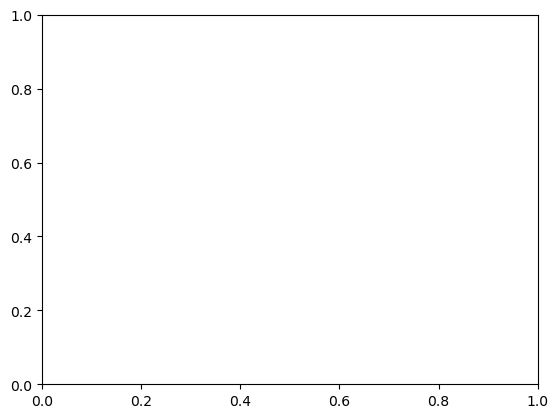

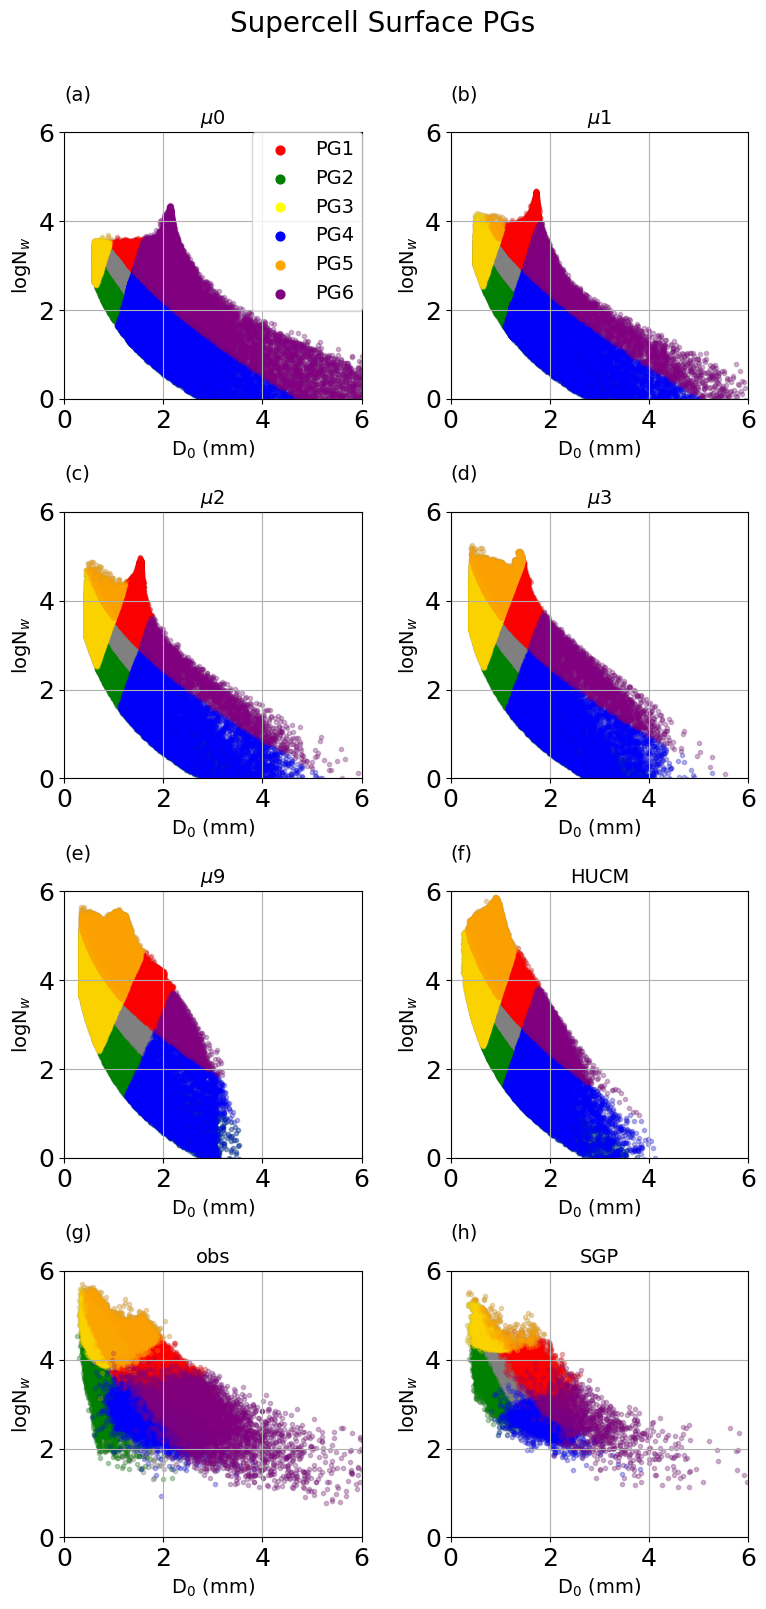

In [17]:
fig, ax = plt.subplots(4,2,figsize=(8,16))
axf = ax.flatten()

#tms = 10
f=0
i=0
axf[i].scatter(-1,-1,color='r',s=40,label='PG1')
axf[i].scatter(-1,-1,color='g',s=40,label='PG2')
axf[i].scatter(-1,-1,color='yellow',s=40,label='PG3')
axf[i].scatter(-1,-1,color='blue',s=40,label='PG4')
axf[i].scatter(-1,-1,color='orange',s=40,label='PG5')
axf[i].scatter(-1,-1,color='purple',s=40,label='PG6')
axf[i].legend(loc=0,
     borderaxespad=0.,fontsize=14,scatterpoints=1,markerscale=1)#,mode='expand')#ld.set_title('Groups')

axf[0] = dfunc.plot_groups(n1filtered_rain_dsd_dict['d00'],(n1filtered_rain_dsd_dict['nww']),n1groups,axf[0])#,line_on=1)#f[0])
handles, labels = axf[0].get_legend_handles_labels()
axf[0].set_title("$\mu$0",fontsize=14)



axf[1] = dfunc.plot_groups(n2filtered_rain_dsd_dict['d00'],(n2filtered_rain_dsd_dict['nww']),n2groups,axf[1])#,line_on=1)#f[0])
handles, labels = axf[1].get_legend_handles_labels()
axf[1].set_title('$\mu$1',fontsize=14)

axf[2] = dfunc.plot_groups(n3filtered_rain_dsd_dict['d00'],(n3filtered_rain_dsd_dict['nww']),n3groups,axf[2])#,line_on=1)#f[0])
handles, labels = axf[2].get_legend_handles_labels()
axf[2].set_title('$\mu$2',fontsize=14)

axf[3] = dfunc.plot_groups(n4filtered_rain_dsd_dict['d00'],(n4filtered_rain_dsd_dict['nww']),n4groups,axf[3])#,line_on=1)#f[0])
handles, labels = axf[3].get_legend_handles_labels()
axf[3].set_title('$\mu$3',fontsize=14)

axf[4] = dfunc.plot_groups(n10filtered_rain_dsd_dict['d00'],(n10filtered_rain_dsd_dict['nww']),n10groups,axf[4])#,line_on=1)#f[0])
handles, labels = axf[4].get_legend_handles_labels()
axf[4].set_title('$\mu$9',fontsize=14)

axf[5] = dfunc.plot_groups(nHfiltered_rain_dsd_dict['d00'],(nHfiltered_rain_dsd_dict['nww']),nHgroups,axf[5])#,line_on=1)#f[0])
handles, labels = axf[5].get_legend_handles_labels()
axf[5].set_title('HUCM',fontsize=14)


axf[6] = dfunc.plot_groups(od0,np.log10(onw),o3groups,axf[6])#,line_on=1)#f[0])
handles, labels = axf[6].get_legend_handles_labels()
axf[6].set_title('obs',fontsize=14)


axf[7] = dfunc.plot_groups(od0[whmc3e],np.log10(onw[whmc3e]),o3groupssgp,axf[7])#,line_on=1)#f[0])
handles, labels = axf[7].get_legend_handles_labels()
axf[7].set_title('SGP',fontsize=14)



for a in axf:
    a.grid()
    a.set_xlim(0,6)
    a.set_ylim(0,6)
    a.set_ylabel('logN$_w$',fontsize=14)
    a.set_xlabel('D$_0$ (mm)',fontsize=14)

    
plt.suptitle(f"Supercell Surface PGs",y=1.01,fontsize=20)
plt.tight_layout()
AT.label_subplots(fig, nlabels=8,fontsize=14)
plt.savefig(f'{fig_dir}Supercell_compareNU_sfcPCA.png',dpi=300,bbox_inches='tight')


